In [1]:
import IPython, nussl, numpy as np, scipy as sp, matplotlib.pyplot as plt, matplotlib, sklearn, librosa, cmath,math,time,vamp
import os,csv
from IPython.display import Audio, display
from scipy.fftpack import fft, ifft
 
# This line makes sure your plots happen IN the webpage you're building, instead of in separate windows.
%matplotlib inline

In [2]:
n_fft = 2048
hop_length = 512
sr = 11025

# get the signal
signal0, sr = librosa.load(path='datasets/genres/blues/blues.00000.au', sr=sr)
signal1, sr = librosa.load(path='datasets/genres/blues/blues.00001.au', sr=sr)
background0, sr = librosa.load(path='datasets/genres-repet/blues/blues.background.00000.au', sr=sr)
background1, sr = librosa.load(path='datasets/genres-repet/blues/blues.background.00001.au', sr=sr)
foreground0, sr = librosa.load(path='datasets/genres-repet/blues/blues.foreground.00000.au', sr=sr)
foreground1, sr = librosa.load(path='datasets/genres-repet/blues/blues.foreground.00001.au', sr=sr)
harmonic0, sr = librosa.load(path='datasets/genres-hpss/blues/blues.harmonic.00000.au', sr=sr)
harmonic1, sr = librosa.load(path='datasets/genres-hpss/blues/blues.harmonic.00001.au', sr=sr)
percussive0, sr = librosa.load(path='datasets/genres-hpss/blues/blues.percussive.00000.au', sr=sr)
percussive1, sr = librosa.load(path='datasets/genres-hpss/blues/blues.percussive.00001.au', sr=sr)

In [3]:
vamp.list_plugins()

['bbc-vamp-plugins:bbc-energy',
 'bbc-vamp-plugins:bbc-intensity',
 'bbc-vamp-plugins:bbc-peaks',
 'bbc-vamp-plugins:bbc-rhythm',
 'bbc-vamp-plugins:bbc-spectral-contrast',
 'bbc-vamp-plugins:bbc-spectral-flux',
 'bbc-vamp-plugins:bbc-speechmusic-segmenter',
 'beatroot-vamp:beatroot',
 'libvamp_essentia:Dissonance_12',
 'libvamp_essentia:DistributionShape_15',
 'libvamp_essentia:FrequencyBands_36',
 'libvamp_essentia:FrequencyBands_38',
 'libvamp_essentia:GFCC_40',
 'libvamp_essentia:HFC_3',
 'libvamp_essentia:HPCP_29',
 'libvamp_essentia:Inharmonicity_13',
 'libvamp_essentia:LPC_19',
 'libvamp_essentia:MFCC_35',
 'libvamp_essentia:MFCC_6',
 'libvamp_essentia:MelBands_34',
 'libvamp_essentia:OddToEvenHarmonicEnergyRatio_37',
 'libvamp_essentia:OnsetDetection_32',
 'libvamp_essentia:OnsetDetection_33',
 'libvamp_essentia:PitchYinFFT_11',
 'libvamp_essentia:SpectralContrast_17',
 'libvamp_essentia:SpectralPeaks_31',
 'libvamp_essentia:SpectralWhitening_30',
 'libvamp_essentia:Tristimulus

The following functions are used to calculates a 9 dimensional vector corresponding to the musical surface features outlined section 3.1 in Tzanetazis's Automatic Musical Genre Classification Of Audio Signals. The paper can be found by following the link below:
http://www.cs.northwestern.edu/~pardo/courses/eecs352/papers/genre%20classification%20low%20level%20-%20tzanetakis.pdf

In [4]:
def meanAndStandardDeviationCentroid(signal, sample_rate):
    """
    computes the mean and standard deviation centroid, given an audio vector of an audio file
    """
    centroid = vamp.collect(signal,sample_rate,'vamp-libxtract:spectral_centroid')['vector'][1]
    mean = np.mean(centroid)
    standard_dev = np.std(centroid)
    return mean, standard_dev

def meanAndStandardDeviationRolloff(signal, sample_rate):
    """
    computes the mean and standard deviation rolloff, given an audio vector of an audio file
    """
    rolloff = vamp.collect(signal,sample_rate,'vamp-libxtract:rolloff')['vector'][1]
    
    mean = np.mean(rolloff)
    standard_dev = np.std(rolloff)
    return mean, standard_dev
    
def zeroCrossings(signal,sample_rate):
    """
    computes zero crossings value of a signal
    """
    zero_crossings = vamp.collect(signal,sample_rate,'vamp-libxtract:zcr')['vector'][1]
    
    mean = np.mean(zero_crossings)
    standard_dev = np.std(zero_crossings)
    return mean,standard_dev

def flux(signal,sample_rate):
    """
    computes the flux of a signal
    """
    flux = vamp.collect(signal,sample_rate,'bbc-vamp-plugins:bbc-spectral-flux')['vector'][1]
    
    mean = np.mean(flux)
    standard_dev = np.std(flux)
    return mean,standard_dev

def low_energy(signal,sample_rate):
    """
    computes the low_energy value for a signal
    """
    energy = a=vamp.collect(signal,sample_rate,'bbc-vamp-plugins:bbc-energy')['vector'][1]
    
    mean = np.mean(energy)
    count = 0.
    for el in energy:
        if el < mean:
            count += 1
    return count/float(len(energy))

def surface_features(signal, sample_rate):
    """
    Calculates a 9 dimensional vector corresponding to the musical surface features outlined in Tzanetazis's Automatic Musical Genre Classification
    Of Audio Signals
    """
    mean_centroid,std_centroid = meanAndStandardDeviationCentroid(signal, sample_rate)
    mean_rolloff,std_rolloff = meanAndStandardDeviationRolloff(signal, sample_rate)
    mean_zcr,std_zcr = zeroCrossings(signal, sample_rate)
    mean_flux,std_flux = flux(signal, sample_rate)
    low_e = low_energy(signal, sample_rate)
    surface_features = np.array([mean_centroid,std_centroid,mean_rolloff,std_rolloff,mean_zcr,std_zcr,mean_flux,std_flux,low_e])
    return surface_features

The following functions are used to calculate a 8 dimensional vector corresponding to the rhythmic features outlined section 3.2 in Tzanetazis's Automatic Musical Genre Classification Of Audio Signals.

In [13]:
def rhythm_features(signal,sample_rate):
    oenv = librosa.onset.onset_strength(y=signal, sr=sample_rate)
    tempo = estimate_tempo(oenv,sample_rate)
    return np.array([tempo])

def estimate_tempo(oenv,sample_rate):
    return librosa.beat.estimate_tempo(oenv,sr=sample_rate)

In [6]:
## given an audio file, computes a feature vector 
def make_feature_vector(file_path, sample_rate):
    signal, sr = librosa.load(path=file_path, sr=sample_rate)
    s_f = surface_features(signal, sr)
    r_f = rhythm_features(signal, sr)
    genre_name = file_path.split('/')[-1].split('.')[0]
    
    feature_vector = np.concatenate((s_f, r_f, np.array([genre_name])))
    return feature_vector
    

In [7]:
def create_datasets(sample_rate):
    dirs = ['datasets/genres','datasets/genres-hpss','datasets/genres-repet']
    types = [[],['percussive','harmonic'],['foreground','background']]

    names = [d for d in os.listdir('datasets/genres') if os.path.isdir(os.path.join('datasets/genres', d))]
    
    if not os.path.exists('features'):
        os.makedirs('features')
        
    #control
    control = []
    for name in names:
        for i in range(0,100):
            if i > 9:
                j = str(i)
            else:
                j = '0' + str(i)
            path = dirs[0]+'/'+name+'/'+name+'.000'+j+'.au'
            control.append(make_feature_vector(path,sample_rate))
    src = 'features/control.csv'
    with open(src,'wb') as csvfile:
        writer = csv.writer(csvfile)
        for row in control:
            writer.writerow(row)
            
    #others
    for i in range(1,3):
        for j in range(0,2):
            features = []
            for name in names:
                for x in range(0,100):
                    if x > 9:
                        y = str(x)
                    else:
                        y = '0'+str(x)
                    path = dirs[i]+'/'+name+'/'+name+'.'+types[i][j]+'.000'+y+'.au'
                    features.append(make_feature_vector(path,sample_rate))
            src = 'features/'+dirs[i].split('-')[1]+'_'+types[i][j]+'.csv'
            with open(src,'wb') as csvfile:
                writer = csv.writer(csvfile)
                for row in features:
                    writer.writerow(row)

Testing stuff below:

In [12]:
rhythm_features(signal0,sr)

array([], dtype=float64)

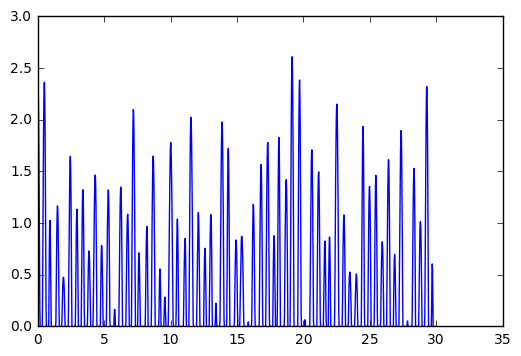

In [9]:
lst = vamp.collect(signal0,sr,'bbc-vamp-plugins:bbc-rhythm')['list']
times = []
magnitudes = []
for el in lst:
    times.append(float(el['timestamp']))
    magnitudes.append(el['values'][0])
plt.plot(times,magnitudes)

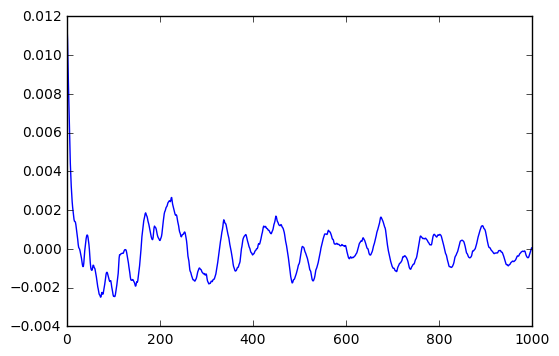

In [10]:
a=acorr(signal1)
plt.plot(a[:1000])